In [ ]:
# Mount Google Drive
from google.colab import drive
import os

# Disable Weights & Biases tracking
os.environ["WANDB_DISABLED"] = "true"

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define directories and file paths
main_dir = "/content/drive/MyDrive/ITCS6156_BERT"
result_dir = os.path.join(main_dir, "Results")
data_dir = os.path.join(main_dir, "Data_Multilabel")
data_path = os.path.join(data_dir, "movies.csv")

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load data
df_movies = pd.read_csv(data_path)

# Pre-process data
df_movies = df_movies[['MOVIES', 'GENRE', 'ONE-LINE']]
df_movies = df_movies.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df_movies = df_movies.drop_duplicates(subset=["MOVIES", "GENRE", "ONE-LINE"])
df_movies = df_movies.dropna(subset=['GENRE'])
df_movies = df_movies.apply(lambda col: col.str.replace('\n', '', regex=True) if col.dtype == 'object' else col)
df_movies = df_movies[df_movies['ONE-LINE'] != "add a plot"]
df_movies = df_movies.reset_index(drop=True)

# Combine title and description for text input
df_movies["TEXT"] = df_movies["MOVIES"] + " " + df_movies["ONE-LINE"]

<ipython-input-3-519cdefb40e8>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_movies = df_movies.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

df_movies['GENRE_LIST'] = df_movies['GENRE'].apply(lambda x: [genre.strip() for genre in x.split(",")])

mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(df_movies['GENRE_LIST'])

genre_encoded_df = pd.DataFrame(encoded_genres, columns=mlb.classes_)
df_movies = pd.concat([df_movies, genre_encoded_df], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df_movies["TEXT"], df_movies["GENRE_LIST"], test_size=0.2, random_state=42)

In [ ]:
print(f"Training set size: {train_texts.shape[0]}")
print(f"Test set size: {val_texts.shape[0]}")

Training set size: 6929
Test set size: 1733


In [ ]:
from transformers import DistilBertTokenizer

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize text data
movies_encodings = tokenizer(list(df_movies["TEXT"]), truncation=True, padding=True, max_length=256)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import tensorflow as tf

# Tokenize train and validation data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), tf.convert_to_tensor(mlb.transform(train_labels), dtype=tf.float32))).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), tf.convert_to_tensor(mlb.transform(val_labels), dtype=tf.float32))).batch(16)

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig

# Load pre-trained DistilBERT model for multi-label classification
num_labels = len(mlb.classes_)
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels, hidden_dropout_prob=0.2, problem_type="multi_label_classification")

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=7e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3
434/434 [==============================] - 4946s 11s/step - loss: 0.2146 - accuracy: 0.3357 - val_loss: 0.1584 - val_accuracy: 0.4570
Epoch 2/3
434/434 [==============================] - 4886s 11s/step - loss: 0.1357 - accuracy: 0.5249 - val_loss: 0.1398 - val_accuracy: 0.5211
Epoch 3/3
434/434 [==============================] - 4858s 11s/step - loss: 0.0970 - accuracy: 0.5906 - val_loss: 0.1339 - val_accuracy: 0.5124


In [ ]:
# Predict on validation data
predictions = model.predict(val_dataset)

# Convert predictions back to genre labels
predicted_labels = mlb.inverse_transform((predictions.logits > 0.5).astype(int))

# print(predicted_labels)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# Convert predictions to binary format
binary_predictions = (predictions.logits > 0.5).astype(int)

# Convert validation labels to binary format
binary_val_labels = mlb.transform(val_labels)

# Compute confusion matrices for each label
confusion_matrices = multilabel_confusion_matrix(binary_val_labels, binary_predictions)

In [ ]:
class_labels = mlb.classes_
for label, matrix in zip(class_labels, confusion_matrices):
    print(f"< {label.capitalize()} >")
    print(pd.DataFrame(matrix,
                       index=["Actual Negative", "Actual Positive"],
                       columns=["Predicted Negative", "Predicted Positive"]))
    print()

< Action >
                 Predicted Negative  Predicted Positive
Actual Negative                1262                  44
Actual Positive                 143                 284

< Adventure >
                 Predicted Negative  Predicted Positive
Actual Negative                1397                  29
Actual Positive                 115                 192

< Animation >
                 Predicted Negative  Predicted Positive
Actual Negative                1421                  31
Actual Positive                  56                 225

< Biography >
                 Predicted Negative  Predicted Positive
Actual Negative                1673                   0
Actual Positive                  59                   1

< Comedy >
                 Predicted Negative  Predicted Positive
Actual Negative                1084                 152
Actual Positive                 134                 363

< Crime >
                 Predicted Negative  Predicted Positive
Actual Negative          

Confusion Matrices


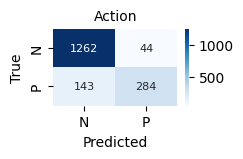

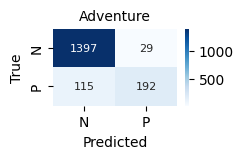

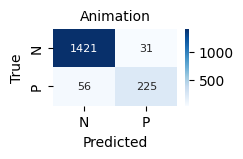

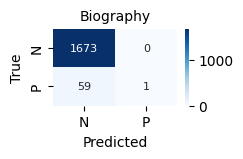

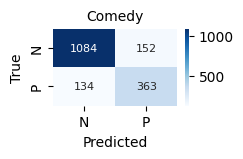

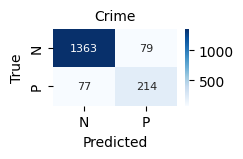

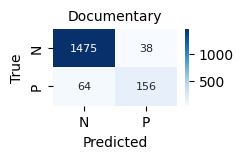

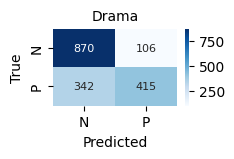

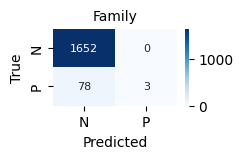

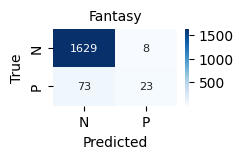

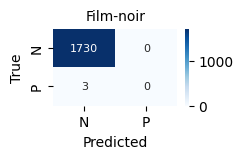

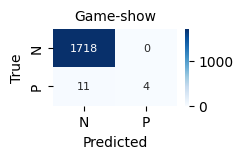

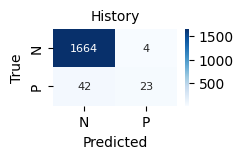

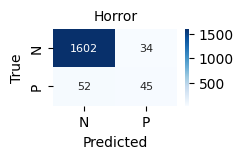

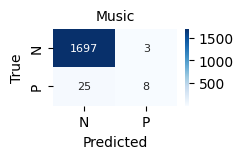

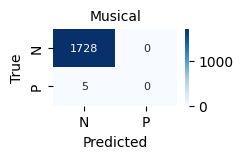

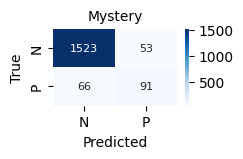

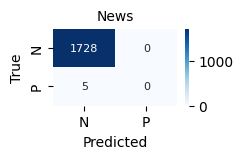

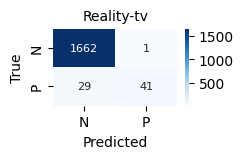

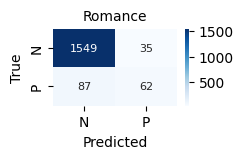

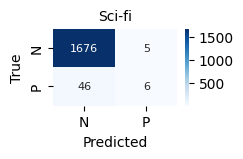

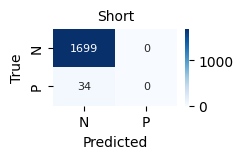

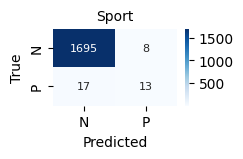

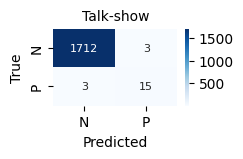

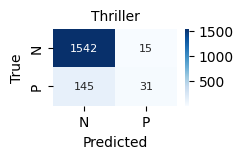

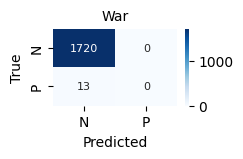

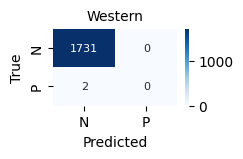

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Confusion Matrices")

# Plot confusion matrix for a specific label
for idx, genre in enumerate(mlb.classes_):
    cm = confusion_matrices[idx]
    plt.figure(figsize=(2, 1))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["N", "P"], yticklabels=["N", "P"], annot_kws={"size": 8})
    plt.title(genre.capitalize(), fontsize=10)
    plt.xlabel("Predicted", fontsize=10)
    plt.ylabel("True", fontsize=10)
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(binary_val_labels, binary_predictions)

print("\nClassification Report:")
print(classification_report(binary_val_labels, binary_predictions, target_names=mlb.classes_))
print(f"\nAccuracy: {accuracy:.2f}\n\n")


Classification Report:
              precision    recall  f1-score   support

      action       0.87      0.67      0.75       427
   adventure       0.87      0.63      0.73       307
   animation       0.88      0.80      0.84       281
   biography       1.00      0.02      0.03        60
      comedy       0.70      0.73      0.72       497
       crime       0.73      0.74      0.73       291
 documentary       0.80      0.71      0.75       220
       drama       0.80      0.55      0.65       757
      family       1.00      0.04      0.07        81
     fantasy       0.74      0.24      0.36        96
   film-noir       0.00      0.00      0.00         3
   game-show       1.00      0.27      0.42        15
     history       0.85      0.35      0.50        65
      horror       0.57      0.46      0.51        97
       music       0.73      0.24      0.36        33
     musical       0.00      0.00      0.00         5
     mystery       0.63      0.58      0.60       157
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
